## Import data_utils

In [7]:
from climsim_utils.data_utils import *

## Instantiate class

In [8]:
grid_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/grid_info/ClimSim_low-res_grid-info.nc'
norm_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/preprocessing/normalizations/'

grid_info = xr.open_dataset(grid_path)
input_mean = xr.open_dataset(norm_path + 'inputs/input_mean.nc')
input_max = xr.open_dataset(norm_path + 'inputs/input_max.nc')
input_min = xr.open_dataset(norm_path + 'inputs/input_min.nc')
output_scale = xr.open_dataset(norm_path + 'outputs/output_scale.nc')

data = data_utils(grid_info = grid_info, 
                  input_mean = input_mean, 
                  input_max = input_max, 
                  input_min = input_min, 
                  output_scale = output_scale)

## Load data and set pressure grid

In [9]:
# paths to scoring data
input_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/scoring_input.npy'
target_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/scoring_target.npy'

# paths to model predictions
cvae_pred_path = '/ocean/projects/atm200007p/shared/neurips_proj/final_metrics/predictions/cVAE/cvae_preds_manual.h5'
ed_pred_path = '/ocean/projects/atm200007p/behrens/ED_Behrens_2022/ED_ClimSIM_1_3_pred.npy'
hsr_pred_path = '/ocean/projects/atm200007p/shared/neurips_proj/final_metrics/predictions/HSR/hsr_preds_bestcrps.h5'
rpn_pred_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/figure_ingredients/rpn_pred_v1_stride6.npy'
cnn_pred_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/figure_ingredients/val_predict_cnn_reshaped_stride6_FINAL.npy'
mlp_pred_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/figure_ingredients/001_backup_phase-7_retrained_models_step2_lot-147_trial_0027.best.h5.npy'

# set variables to V1 subset
data.set_to_v1_vars()

# path to target input
data.input_scoring = np.load(input_path)

# path to target output
data.target_scoring = np.load(target_path)

# set pressure weights
data.set_pressure_grid(data_split = 'scoring')

# load model predictions
data.model_names = ['CNN','cVAE','ED','HSR','MLP', 'RPN']
preds = [data.load_npy_file(load_path = cnn_pred_path), 
         data.load_h5_file(load_path = cvae_pred_path),
         data.load_npy_file(load_path = ed_pred_path), 
         data.load_h5_file(load_path = hsr_pred_path), 
         data.load_npy_file(load_path = mlp_pred_path), 
         data.load_npy_file(load_path = rpn_pred_path)]
data.preds_scoring = dict(zip(data.model_names, preds))

## Weight outputs

1. Undo output scaling

2.  Weight vertical levels by dp/g

3. Weight horizontal area of each grid cell by a[x]/mean(a[x])

4. Convert units to a common energy unit

In [10]:
data.reweight_target(data_split = 'scoring')
data.reweight_preds(data_split = 'scoring')

## Calculate biases

In [50]:
results_complete = {}
for model in data.model_names:
    results_temp = {}
    for var in data.target_vars:
        results_temp[var] = data.calc_bias(data.preds_weighted_scoring[model][var], 
                                           data.target_weighted_scoring[var],
                                           avg_grid = False)
    results_complete[model] = results_temp

## Get pressure axis

In [107]:
# get plotting pressure grid
data.data_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train/'

# set regular expressions for selecting data
data.set_regexps(data_split = 'scoring', regexps = ['E3SM-MMF.mli.0008-0[23456789]-*-*.nc', 
                                                    'E3SM-MMF.mli.0008-1[012]-*-*.nc', 
                                                    'E3SM-MMF.mli.0009-01-*-*.nc'])
# set temporal subsampling
data.set_stride_sample(data_split = 'scoring', stride_sample = 6)

# create list of files to extract data from
data.set_filelist(data_split = 'scoring')

# create pressure grid
pressure_grid_plotting = data.get_pressure_grid_plotting(data_split = 'scoring')

# average pressure grid across grid
y_pressure = pressure_grid_plotting.mean(axis = 1)/100

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4380/4380 [00:32<00:00, 135.51it/s]


## Make plots

In [112]:
%config InlineBackend.figure_format = 'retina'
letters = string.ascii_lowercase

Text(0.5, 1.0, 'heating bias')

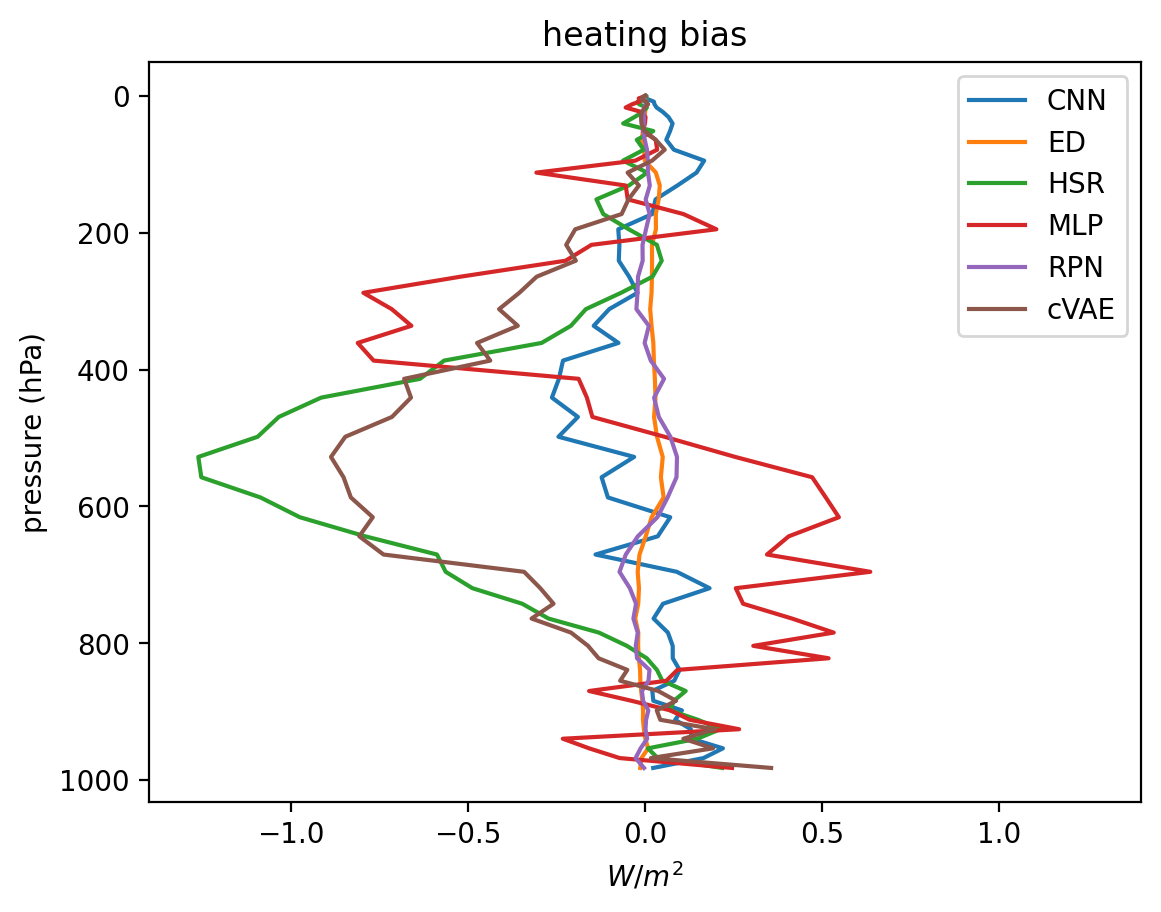

In [110]:
plt.plot(results_complete['CNN']['ptend_t'].mean(axis = 0), y_pressure)
plt.plot(results_complete['ED']['ptend_t'].mean(axis = 0), y_pressure)
plt.plot(results_complete['HSR']['ptend_t'].mean(axis = 0), y_pressure)
plt.plot(results_complete['MLP']['ptend_t'].mean(axis = 0), y_pressure)
plt.plot(results_complete['RPN']['ptend_t'].mean(axis = 0), y_pressure)
plt.plot(results_complete['cVAE']['ptend_t'].mean(axis = 0), y_pressure)

plt.legend(['CNN', 'ED', 'HSR', 'MLP', 'RPN', 'cVAE'])
plt.xlim(-1.4, 1.4)
plt.gca().invert_yaxis()
plt.xlabel('$W/m^2$')
plt.ylabel('pressure (hPa)')
plt.title('heating bias')

Text(0.5, 1.0, 'moistening bias')

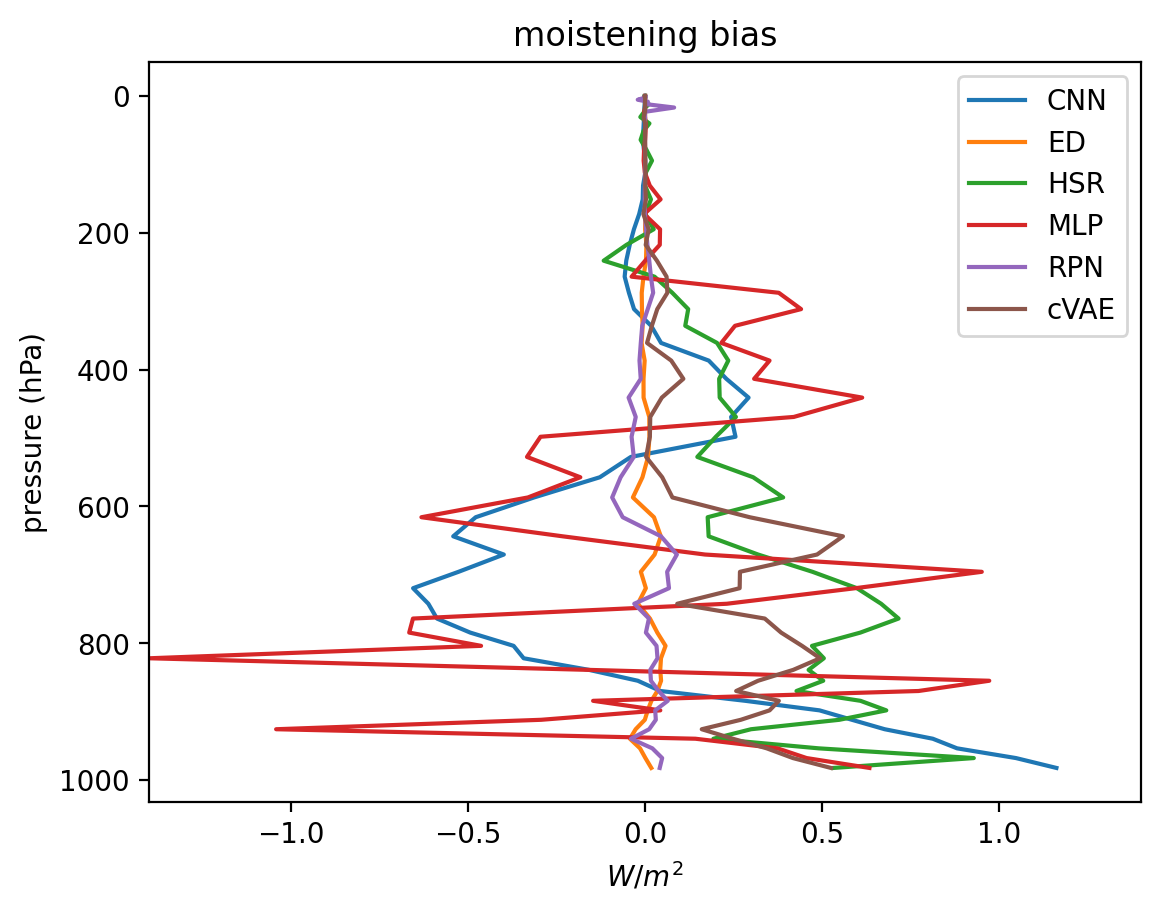

In [111]:
plt.plot(results_complete['CNN']['ptend_q0001'].mean(axis = 0), y_pressure)
plt.plot(results_complete['ED']['ptend_q0001'].mean(axis = 0), y_pressure)
plt.plot(results_complete['HSR']['ptend_q0001'].mean(axis = 0), y_pressure)
plt.plot(results_complete['MLP']['ptend_q0001'].mean(axis = 0), y_pressure)
plt.plot(results_complete['RPN']['ptend_q0001'].mean(axis = 0), y_pressure)
plt.plot(results_complete['cVAE']['ptend_q0001'].mean(axis = 0), y_pressure)

plt.legend(['CNN', 'ED', 'HSR', 'MLP', 'RPN', 'cVAE'])
plt.xlim(-1.4, 1.4)
plt.gca().invert_yaxis()
plt.xlabel('$W/m^2$')
plt.ylabel('pressure (hPa)')
plt.title('moistening bias')

In [124]:
data.metrics_names = ['bias']
data.create_metrics_df(data_split = 'scoring')
bias_df = pd.DataFrame([data.metrics_var_scoring[model]['bias'] for model in data.model_names],
                        index=data.model_names)
bias_df = bias_df.rename(columns = data.var_short_names).transpose()

Text(0.5, 1.0, 'Bias')

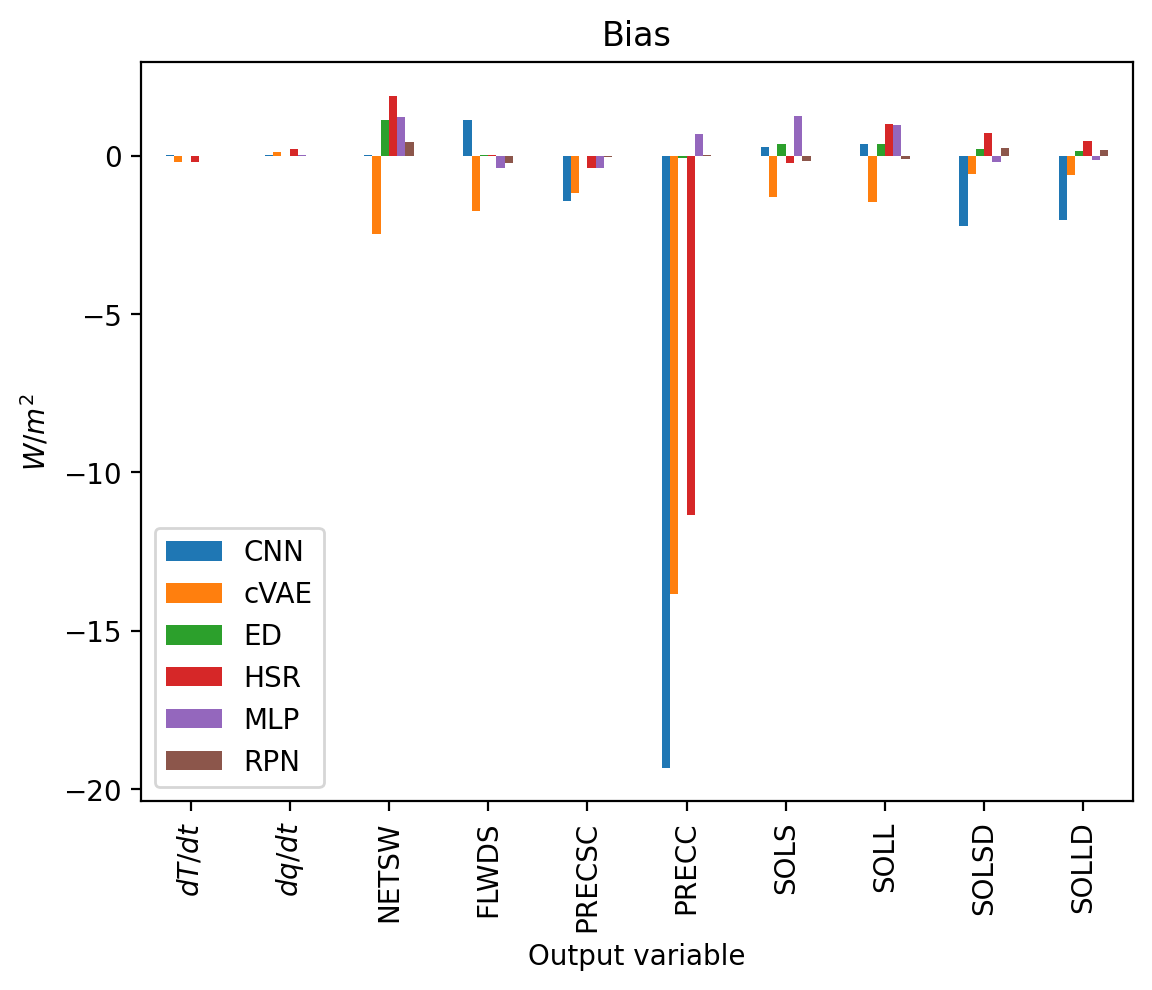

In [139]:
bias_df.plot.bar()
plt.xlabel('Output variable')
plt.ylabel('$W/m^2$')
plt.title('Bias')